In [3]:
from known_boundary.GP import optimise,optimise_warp
from known_boundary.utlis import Trans_function, get_initial_points
import numpy as np
import matplotlib.pyplot as plt
import GPy
import torch
import botorch
from botorch.test_functions import Ackley,Levy,Beale,Branin,Hartmann,Rosenbrock,Powell
from botorch.utils.transforms import unnormalize,normalize
import warnings
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double

/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from known_boundary.GP import optimise,optimise_warp,optimise_warp_no_boundary
from known_boundary.utlis import Trans_function, get_initial_points,transform
import numpy as np
import GPy
import torch
from botorch.test_functions import Ackley,Levy,Beale,Branin,Hartmann,Rosenbrock,Powell
from botorch.utils.transforms import unnormalize,normalize

import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double

In [3]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm

##################### GP acquisition function ########################################################
def EI(X,dim,f_best,model,f_star='no'): # X is a 2-dimensional array because we will use it in scipy.minimize

  X = X.reshape(-1,dim)

  mean,var = model._raw_predict(X) #exclude noise

  if f_star == 'no':
      z = (f_best - mean)/np.sqrt(var)        
      out=(f_best - mean) * norm.cdf(z) + np.sqrt(var) * norm.pdf(z)
  else:
      z = (f_best - mean)/np.sqrt(var)        
      out1=(f_best - mean) * norm.cdf(z) + np.sqrt(var) * norm.pdf(z)
      
      z = (f_star - mean)/np.sqrt(var)        
      out2=(f_star - mean) * norm.cdf(z) + np.sqrt(var) * norm.pdf(z)
      
      part3 = (f_best-f_star)*norm.cdf((f_star - mean)/np.sqrt(var)  )
      
      out = out1 - out2 + part3
    
  
  return out.ravel()  #make the shape to be 1 dimensional




def Warped_EI(X,dim,f_best,c,f_mean,model): # X is a 2-dimensional array because we will use it in scipy.minimize


  X = X.reshape(-1,dim)

  mean,var = model._raw_predict(X) #exclude noise
  
  sigma = np.sqrt(var)
  mu = mean+f_mean

  C = c+f_best
  
  out = C*norm.cdf((np.log(C)-mu)/sigma)-np.exp(mu+sigma**2/2)*norm.cdf((np.log(C)-mu-sigma**2)/sigma)

  return out.ravel()  #make the shape to be 1 dimensional



def Warped_TEI2(X,dim,f_best,c,f_mean,model): # X is a 2-dimensional array because we will use it in scipy.minimize


  X = X.reshape(-1,dim)

  mean,var = model._raw_predict(X) #exclude noise
  sigma = np.sqrt(var)
  mu = mean+f_mean

  C = c+f_best
  
  part1 = C*norm.cdf((np.log(C)-mu)/sigma)-np.exp(mu+sigma**2/2)*norm.cdf((np.log(C)-mu-sigma**2)/sigma)
  
  C = c
  part2 = C*norm.cdf((np.log(C)-mu)/sigma)-np.exp(mu+sigma**2/2)*norm.cdf((np.log(C)-mu-sigma**2)/sigma)
  
  out_temp = part1-part2
  
  part3 = f_best*norm.cdf(  (np.log(c)-mu) /sigma ) 
  
  out = out_temp+part3
  

  return out.ravel()  #make the shape to be 1 dimensional

# GP

In [71]:
def high_dimensional_discretization(bounds,N=50): #bounds shoud always be two dimensional, N is the number of partition in one dimension

  dim = bounds.shape[0]


  bounds = bounds.reshape(dim,-1)
  coords = [np.linspace(bounds[d][0], bounds[d][1], N) for d in range(dim)]
  mesh = np.meshgrid(*coords, indexing='ij')

  coords = np.vstack([x.flatten() for x in mesh]).T

  return coords

In [72]:
class GP_ObjectiveFunction3:  
    def __init__(self,X_history,Y_history,dim=2,lengthscale=0.2,variance=2,seed=0):
      
      self.dim = dim
      self.lengthscale = lengthscale
      self.variance = variance
      #self.bounds = torch.tensor([[0.,1.]]*dim).T
      self.npbounds = np.array([[0.,1.]]*dim)
      self.seed =seed
      
      self.X_history = X_history
      self.Y_history = Y_history
      
      np.random.seed(self.seed) 

      kernel = GPy.kern.RBF(input_dim=dim,variance=self.variance,lengthscale=self.lengthscale)
      model = GPy.models.GPRegression(self.X_history.reshape(-1,dim),self.Y_history.reshape(-1,1),kernel)
      model.Gaussian_noise.variance.fix(0.0)
      
      self.GP = model
      
    
    def return_GP(self):
      
      X_total = high_dimensional_discretization(self.npbounds ,N=51)
      Y_total = self.GP.posterior_samples_f(X_total,size=1).reshape(-1,1)
        
      return X_total, Y_total            
      


In [10]:
dim = 2
seed = 0 

X0 = np.array([0.,0.]).reshape(-1,dim)
Y0 =np.array([np.random.normal(0, np.sqrt(2), size=(1,1))[0]]).reshape(-1,1)
fun = GP_ObjectiveFunction3(X0,Y0,dim=2,lengthscale=0.15,variance=2,seed=seed)
X_total, Y_total    = fun.return_GP()

plot

minimal output is  -4.160305599202833


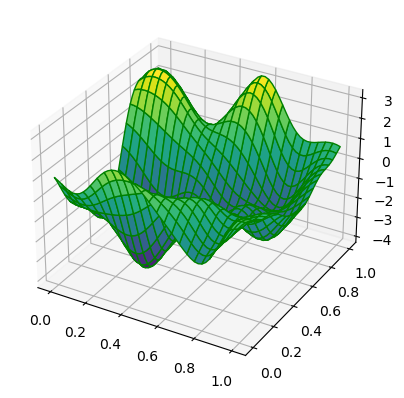

In [11]:
print('minimal output is ',np.min(Y_total))

X1 = np.linspace(0,1,51)
X2 = np.linspace(0,1,51)

X1X2, X2X1 = np.meshgrid(X1,X2)

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1X2, X2X1, Y_total.reshape(51,51), cmap ='viridis', edgecolor ='green')

plt.show()

GP+EI

In [7]:
import random

In [32]:
N = 1
dim = 2
iter_num = 20*dim

In [72]:
EI_res = []

for exp in range (N):
    
    seed = exp
    np.random.seed(seed)

    X0 = np.array([0.,0.]).reshape(-1,dim)
    Y0 =np.array([np.random.normal(0, np.sqrt(2), size=(1,1))[0]]).reshape(-1,1)
    fun = GP_ObjectiveFunction3(X0,Y0,dim=2,lengthscale=0.1,variance=2,seed=seed)
    X_total, Y_total    = fun.return_GP()

    X_init = []
    Y_init = []

    for ii in range(8):

        random.seed(ii)

        lower_bound = 0
        upper_bound = 51**2 - 1
        idx = random.randint(lower_bound, upper_bound)
        X_init.append(X_total[idx])
        Y_init.append(Y_total[idx])
        
    X_BO = np.array(X_init)
    Y_BO = np.array(Y_init)

    fstar = np.min(Y_total)

    best_record = [np.min(Y_BO)-fstar]

    for i in range(iter_num):

            lengthscale = 0.1
            variance = 2
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance) 
            m = GPy.models.GPRegression(X_BO, Y_BO, kernel)
            m.Gaussian_noise.variance.fix(0.0)
            #m.optimize()
            
            AF_holder = EI(X=X_total,dim=dim,f_best=np.min(Y_BO),model=m,f_star='no')
            choice = np.argmax(AF_holder)
            
            X_next = X_total[choice].reshape(-1,dim)
            Y_next = Y_total[choice].reshape(-1,1)
            
            
            X_BO = np.concatenate([X_BO, X_next])
            Y_BO = np.concatenate([Y_BO, Y_next])
            
            best_record.append(np.min(Y_BO)-fstar)
    
    print(best_record[-1])
    best_record = np.array(best_record)       
    EI_res.append(best_record)
        

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0735435046027737
0.0
0.0
0.0
0.0
0.0
0.0045719196616178515
0.0
0.0
0.09842741281694423
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.17025635270889516
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [73]:
EI_res2 = []

for exp in range (N):
    
    
    
    seed = exp
    np.random.seed(seed)

    X0 = np.array([0.,0.]).reshape(-1,dim)
    Y0 =np.array([np.random.normal(0, np.sqrt(2), size=(1,1))[0]]).reshape(-1,1)
    fun = GP_ObjectiveFunction3(X0,Y0,dim=2,lengthscale=0.1,variance=2,seed=seed)
    X_total, Y_total    = fun.return_GP()

    X_init = []
    Y_init = []

    for ii in range(8):

        random.seed(ii)

        lower_bound = 0
        upper_bound = 51**2 - 1
        idx = random.randint(lower_bound, upper_bound)
        X_init.append(X_total[idx])
        Y_init.append(Y_total[idx])
        
    X_BO = np.array(X_init)
    Y_BO = np.array(Y_init)

    fstar = np.min(Y_total)

    best_record = [np.min(Y_BO)-fstar]

    for i in range(iter_num):

            res = optimise(X_BO,Y_BO)
            # print('lengthscale is: ',np.sqrt(res[0])) 
            # print('variance is: ',res[1])
            lengthscale = np.sqrt(res[0])
            variance = res[1]
            
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance) 
            m = GPy.models.GPRegression(X_BO, Y_BO, kernel)
            m.Gaussian_noise.variance.fix(10**(-6))
            #m.optimize()
            
            AF_holder = EI(X=X_total,dim=dim,f_best=np.min(Y_BO),model=m,f_star='no')
            choice = np.argmax(AF_holder)
            
            X_next = X_total[choice].reshape(-1,dim)
            Y_next = Y_total[choice].reshape(-1,1)
            
            
            X_BO = np.concatenate([X_BO, X_next])
            Y_BO = np.concatenate([Y_BO, Y_next])
            
            best_record.append(np.min(Y_BO)-fstar)
    
    print(best_record[-1])
    best_record = np.array(best_record)       
    EI_res2.append(best_record)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.7480959555096156
0.0
0.0
0.0
0.0
0.0
0.0
0.06716653276618123
0.5258340737099907
0.0
0.0
0.18390001049036098
0.0
0.0
0.0
0.0
0.09842741281694423
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.13546848520419852
0.0
0.0
0.0
0.7171674605282501
0.6394214594008885
0.0
0.0


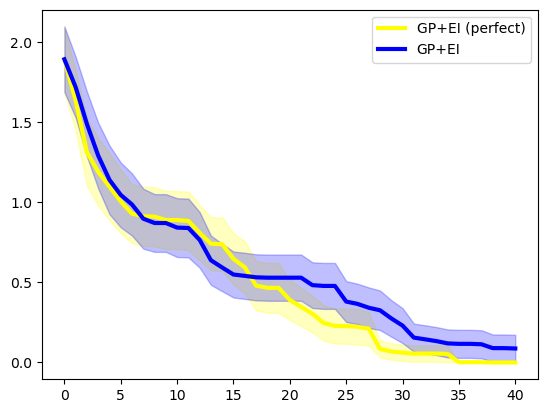

In [27]:
total_record = (np.array(EI_res))
total_record[total_record<=0]=10**(-4)
total_record = (total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP+EI (perfect)',color='yellow')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='yellow')

total_record = (np.array(EI_res2))
total_record[total_record<=0]=10**(-4)
total_record = (total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP+EI',color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='blue')

plt.legend()

logEI (no boundary)

In [48]:
logEI_noboundary_res = []

for exp in range (N):
    
    seed = 2
    np.random.seed(seed)

    X0 = np.array([0.,0.]).reshape(-1,dim)
    Y0 =np.array([np.random.normal(0, np.sqrt(2), size=(1,1))[0]]).reshape(-1,1)
    fun = GP_ObjectiveFunction3(X0,Y0,dim=2,lengthscale=0.1,variance=2,seed=seed)
    X_total, Y_total    = fun.return_GP()

    X_init = []
    Y_init = []

    for ii in range(8):

        random.seed(ii)

        lower_bound = 0
        upper_bound = 51**2 - 1
        idx = random.randint(lower_bound, upper_bound)
        X_init.append(X_total[idx])
        Y_init.append(Y_total[idx])
        
    X_BO = np.array(X_init)
    Y_BO = np.array(Y_init)

    fstar = np.min(Y_total)

    best_record = [np.min(Y_BO)-fstar]

    for i in range(4):
        
            #print(i)

            res = optimise_warp_no_boundary(X_BO,Y_BO,-fstar+2.5)

            lengthscale = np.sqrt(res[0])
            variance = res[1]
            c = res[2]
            print('lengthscale is: ', lengthscale)
            print('variance is: ',variance)
            print('c is: ',c)
            
            warp_Y = np.log(Y_BO+c)
            mean_warp_Y = np.mean(warp_Y) # use to predict mean
            warp_Y_standard = warp_Y-mean_warp_Y
            
            
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance) 
            m = GPy.models.GPRegression(X_BO, warp_Y_standard,kernel)
            m.Gaussian_noise.variance.fix(10**(-6))

            
            # print('lengthscale is: ', lengthscale)
            # print('variance is: ',variance)
            # print('c is: ',c)
            AF_holder =  Warped_EI(X=X_total,dim=dim,f_best=np.min(Y_BO),c=c,f_mean=mean_warp_Y,model=m)
            choice = np.argmax(AF_holder)
            
            X_next = X_total[choice].reshape(-1,dim)
            Y_next = Y_total[choice].reshape(-1,1)
            
            
            X_BO = np.concatenate([X_BO, X_next])
            Y_BO = np.concatenate([Y_BO, Y_next])
            
            best_record.append(np.min(Y_BO)-fstar)
    
    print(best_record[-1])
    best_record = np.array(best_record)       
    logEI_noboundary_res.append(best_record)

lengthscale is:  0.05355199563812739
variance is:  0.04893800298470457
c is:  6.709870306717928
lengthscale is:  0.15009704263904305
variance is:  0.7697557081834097
c is:  1.6411838437464479
lengthscale is:  0.07250315864099076
variance is:  0.0436343823222251
c is:  6.709870306717928
lengthscale is:  0.08319497218030686
variance is:  0.0497607361267065
c is:  7.764570092599564
0.1730642001626128


In [49]:
warp_Y

array([[1.87616984],
       [2.35295885],
       [2.04673062],
       [2.0014672 ],
       [2.07865304],
       [2.39214446],
       [2.20139804],
       [2.45435721],
       [1.88690488],
       [2.08759519],
       [1.69996432]])

In [50]:
mean_warp_Y

2.0980312399086283

In [51]:
warp_Y_standard

array([[-0.2218614 ],
       [ 0.25492761],
       [-0.05130062],
       [-0.09656404],
       [-0.0193782 ],
       [ 0.29411322],
       [ 0.1033668 ],
       [ 0.35632597],
       [-0.21112636],
       [-0.01043605],
       [-0.39806692]])

logEI (with boundary)

In [75]:
logEI_res = []

for exp in range (N):
    
    seed = exp
    np.random.seed(seed)
    
    X0 = np.array([0.,0.]).reshape(-1,dim)
    Y0 =np.array([np.random.normal(0, np.sqrt(2), size=(1,1))[0]]).reshape(-1,1)
    fun = GP_ObjectiveFunction3(X0,Y0,dim=2,lengthscale=0.1,variance=2,seed=seed)
    X_total, Y_total    = fun.return_GP()
    
    fstar = np.min(Y_total)
    Y_total = Y_total - fstar
    
    X_init = []
    Y_init = []

    for ii in range(8):

        random.seed(ii)

        lower_bound = 0
        upper_bound = 51**2 - 1
        idx = random.randint(lower_bound, upper_bound)
        X_init.append(X_total[idx])
        Y_init.append(Y_total[idx])
        
    X_BO = np.array(X_init)
    Y_BO = np.array(Y_init)


    best_record = [np.min(Y_BO)-0]


    for i in range(iter_num):
        
            #print(i)

            res = optimise_warp(X_BO, Y_BO)

            lengthscale = np.sqrt(res[0])
            variance = res[1]
            c = res[2]
            # print('lengthscale is: ', lengthscale)
            # print('variance is: ',variance)
            # print('c is: ',c)
            
            warp_Y = np.log(Y_BO+c)
            mean_warp_Y = np.mean(warp_Y) # use to predict mean
            warp_Y_standard = warp_Y-mean_warp_Y
            
            
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance) 
            m = GPy.models.GPRegression(X_BO, warp_Y_standard,kernel)
            m.Gaussian_noise.variance.fix(10**(-6))

            
            
            AF_holder =  Warped_EI(X=X_total,dim=dim,f_best=np.min(Y_BO),c=c,f_mean=mean_warp_Y,model=m)
            choice = np.argmax(AF_holder)
            
            X_next = X_total[choice].reshape(-1,dim)
            Y_next = Y_total[choice].reshape(-1,1)
            
            
            X_BO = np.concatenate([X_BO, X_next])
            Y_BO = np.concatenate([Y_BO, Y_next])
            
            best_record.append(np.min(Y_BO)-0)
    
    print(best_record[-1])
    best_record = np.array(best_record)       
    logEI_res.append(best_record)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.03240368140575356
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31303855380345036
0.0
0.0
0.0
0.09842741281694423
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.19718253310306766
0.0
0.17025635270889516
0.0
0.0
0.0
0.0028358656124702897
0.6394214594008885
0.0
0.0


logTEI

In [81]:
logTEI_res = []

for exp in range (N):
    
    seed = exp
    np.random.seed(seed)
    
    X0 = np.array([0.,0.]).reshape(-1,dim)
    Y0 =np.array([np.random.normal(0, np.sqrt(2), size=(1,1))[0]]).reshape(-1,1)
    fun = GP_ObjectiveFunction3(X0,Y0,dim=2,lengthscale=0.1,variance=2,seed=seed)
    X_total, Y_total    = fun.return_GP()
    
    fstar = np.min(Y_total)
    Y_total = Y_total - fstar
    
    X_init = []
    Y_init = []

    for ii in range(8):

        random.seed(ii)

        lower_bound = 0
        upper_bound = 51**2 - 1
        idx = random.randint(lower_bound, upper_bound)
        X_init.append(X_total[idx])
        Y_init.append(Y_total[idx])
        
    X_BO = np.array(X_init)
    Y_BO = np.array(Y_init)


    best_record = [np.min(Y_BO)-0]


    for i in range(iter_num):
        
            print(i)

            res = optimise_warp(X_BO, Y_BO)

            lengthscale = np.sqrt(res[0])
            variance = res[1]
            c = res[2]
            # print('lengthscale is: ', lengthscale)
            # print('variance is: ',variance)
            # print('c is: ',c)
            
            warp_Y = np.log(Y_BO+c)
            mean_warp_Y = np.mean(warp_Y) # use to predict mean
            warp_Y_standard = warp_Y-mean_warp_Y
            
            
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance) 
            m = GPy.models.GPRegression(X_BO, warp_Y_standard,kernel)
            m.Gaussian_noise.variance.fix(10**(-6))

            
            
            AF_holder =  Warped_TEI2(X=X_total,dim=dim,f_best=np.min(Y_BO),c=c,f_mean=mean_warp_Y,model=m)
            choice = np.argmax(AF_holder)
            
            X_next = X_total[choice].reshape(-1,dim)
            Y_next = Y_total[choice].reshape(-1,1)
            
            
            X_BO = np.concatenate([X_BO, X_next])
            Y_BO = np.concatenate([Y_BO, Y_next])
            
            best_record.append(np.min(Y_BO)-0)
    
    print(best_record[-1])
    best_record = np.array(best_record)       
    logTEI_res.append(best_record)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
0.0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
0.0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
0.0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
0.0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
0.0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
0.0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
0.0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
0.0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32

# Log GP

In [70]:
class logGP_ObjectiveFunction3:  
    def __init__(self,X_history,Y_history,dim=2,lengthscale=0.2,variance=2,seed=0):
      
      self.dim = dim
      self.lengthscale = lengthscale
      self.variance = variance
      #self.bounds = torch.tensor([[0.,1.]]*dim).T
      self.npbounds = np.array([[0.,1.]]*dim)
      self.seed =seed
      
      self.X_history = X_history
      self.Y_history = Y_history
      
      np.random.seed(self.seed) 

      kernel = GPy.kern.RBF(input_dim=dim,variance=self.variance,lengthscale=self.lengthscale)
      model = GPy.models.GPRegression(self.X_history.reshape(-1,dim),self.Y_history.reshape(-1,1),kernel)
      model.Gaussian_noise.variance.fix(0.0)
      
      self.GP = model
      
    
    def return_logGP(self):
      
      X_total = high_dimensional_discretization(self.npbounds ,N=51)
      Y_total = self.GP.posterior_samples_f(X_total,size=1).reshape(-1,1)
      
      Y_total = np.exp(Y_total)-1.
        
      return X_total, Y_total            
      

In [6]:
dim = 2
seed = 0 

X0 = np.array([0.,0.]).reshape(-1,dim)
Y0 =np.array([np.random.normal(0, np.sqrt(2), size=(1,1))[0]]).reshape(-1,1)
fun = logGP_ObjectiveFunction3(X0,Y0,dim=2,lengthscale=0.15,variance=2,seed=seed)
X_total, Y_total    = fun.return_logGP()

minimal output is  -0.9844069015677259


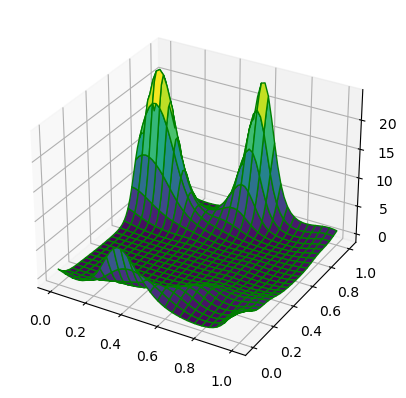

In [7]:
print('minimal output is ',np.min(Y_total))

X1 = np.linspace(0,1,51)
X2 = np.linspace(0,1,51)

X1X2, X2X1 = np.meshgrid(X1,X2)

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1X2, X2X1, Y_total.reshape(51,51), cmap ='viridis', edgecolor ='green')

plt.show()

EI

In [8]:
N = 50
dim = 2
iter_num = 20*dim

In [9]:
EI_res2 = []

for exp in range (N):
    
    
    
    seed = exp
    np.random.seed(seed)

    X0 = np.array([0.,0.]).reshape(-1,dim)
    Y0 =np.array([np.random.normal(0, np.sqrt(2), size=(1,1))[0]]).reshape(-1,1)
    fun = logGP_ObjectiveFunction3(X0,Y0,dim=2,lengthscale=0.1,variance=2,seed=seed)
    X_total, Y_total    = fun.return_logGP()

    X_init = []
    Y_init = []

    for ii in range(8):

        random.seed(ii)

        lower_bound = 0
        upper_bound = 51**2 - 1
        idx = random.randint(lower_bound, upper_bound)
        X_init.append(X_total[idx])
        Y_init.append(Y_total[idx])
        
    X_BO = np.array(X_init)
    Y_BO = np.array(Y_init)

    fstar = np.min(Y_total)
    
    print('fstar: ',fstar)

    best_record = [np.min(Y_BO)-fstar]

    for i in range(iter_num):

            res = optimise(X_BO,Y_BO)
            # print('lengthscale is: ',np.sqrt(res[0])) 
            # print('variance is: ',res[1])
            lengthscale = np.sqrt(res[0])
            variance = res[1]
            
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance) 
            m = GPy.models.GPRegression(X_BO, Y_BO, kernel)
            m.Gaussian_noise.variance.fix(10**(-6))
            
            AF_holder = EI(X=X_total,dim=dim,f_best=np.min(Y_BO),model=m,f_star='no')
            choice = np.argmax(AF_holder)
            
            X_next = X_total[choice].reshape(-1,dim)
            Y_next = Y_total[choice].reshape(-1,1)
            
            
            X_BO = np.concatenate([X_BO, X_next])
            Y_BO = np.concatenate([Y_BO, Y_next])
            
            best_record.append(np.min(Y_BO)-fstar)
    
    print(best_record[-1])
    best_record = np.array(best_record)       
    EI_res2.append(best_record)

fstar:  -0.995495185439
0.0
fstar:  -0.983264779553281
0.008192432009648254
fstar:  -0.9488888234634211
0.0026488393195721605
fstar:  -0.9919224204182131
0.005628134250708849
fstar:  -0.9386879789433674
0.006619445238961852
fstar:  -0.9905035598903508
0.00044874242066328396
fstar:  -0.9906721043042017
0.004531337703234106
fstar:  -0.9723187899031059
0.004656727773305613
fstar:  -0.9916707452427579
0.007861764987724063
fstar:  -0.9581258380817942
0.0008311597058504594
fstar:  -0.985484936909411
0.0004886760315436778
fstar:  -0.973255841443226
0.006789502089928678
fstar:  -0.9791007751674399
0.0032187162025555383
fstar:  -0.9806840448402734
0.010399972397867607
fstar:  -0.9912414001835659
0.029907695749828656
fstar:  -0.9747603612970877
0.014009816192784741
fstar:  -0.9777992822593902
0.0026325428949514063
fstar:  -0.9850723963430124
0.0023500610823955492
fstar:  -0.9860389022614812
0.004295602788919717
fstar:  -0.9726116599132804
0.0014850671306422258
fstar:  -0.985393428985038
0.007993

In [10]:
logEI_noboundary_res = []

for exp in range (N):
    
    seed = exp
    np.random.seed(seed)

    X0 = np.array([0.,0.]).reshape(-1,dim)
    Y0 =np.array([np.random.normal(0, np.sqrt(2), size=(1,1))[0]]).reshape(-1,1)
    fun = logGP_ObjectiveFunction3(X0,Y0,dim=2,lengthscale=0.1,variance=2,seed=seed)
    X_total, Y_total    = fun.return_logGP()

    X_init = []
    Y_init = []

    for ii in range(8):

        random.seed(ii)

        lower_bound = 0
        upper_bound = 51**2 - 1
        idx = random.randint(lower_bound, upper_bound)
        X_init.append(X_total[idx])
        Y_init.append(Y_total[idx])
        
    X_BO = np.array(X_init)
    Y_BO = np.array(Y_init)

    fstar = np.min(Y_total)

    best_record = [np.min(Y_BO)-fstar]

    for i in range(iter_num):
        
            #print(i)

            res = optimise_warp_no_boundary(X_BO,Y_BO,-fstar+1.5)

            lengthscale = np.sqrt(res[0])
            variance = res[1]
            c = res[2]
            print('lengthscale is: ', lengthscale)
            print('variance is: ',variance)
            print('c is: ',c)
            
            warp_Y = np.log(Y_BO+c)
            mean_warp_Y = np.mean(warp_Y) # use to predict mean
            warp_Y_standard = warp_Y-mean_warp_Y
            
            
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance) 
            m = GPy.models.GPRegression(X_BO, warp_Y_standard,kernel)
            m.Gaussian_noise.variance.fix(10**(-6))


            AF_holder =  Warped_EI(X=X_total,dim=dim,f_best=np.min(Y_BO),c=c,f_mean=mean_warp_Y,model=m)
            choice = np.argmax(AF_holder)
            
            X_next = X_total[choice].reshape(-1,dim)
            Y_next = Y_total[choice].reshape(-1,1)
            
            
            X_BO = np.concatenate([X_BO, X_next])
            Y_BO = np.concatenate([Y_BO, Y_next])
            
            best_record.append(np.min(Y_BO)-fstar)
    
    print(best_record[-1])
    best_record = np.array(best_record)       
    logEI_noboundary_res.append(best_record)

lengthscale is:  0.015
variance is:  0.9031615663113183
c is:  1.0828968997378114
lengthscale is:  0.09736980723245578
variance is:  2.0458353942062244
c is:  0.9449092048650366
lengthscale is:  0.17248319993814637
variance is:  2.4394123642273144
c is:  0.974268350835439
lengthscale is:  0.1415684685754528
variance is:  1.6905699243867822
c is:  0.9986212708622921
lengthscale is:  0.147780597277276
variance is:  1.7286420335543253
c is:  0.9974159085609391
lengthscale is:  0.14746386014448376
variance is:  1.7134132986317399
c is:  1.0275205612239466
lengthscale is:  0.1289097389218482
variance is:  1.5879040965728815
c is:  1.0204342198491723
lengthscale is:  0.103272112665424
variance is:  1.7881604463264713
c is:  0.9923632927049273
lengthscale is:  0.12009727337828828
variance is:  1.3137735237002506
c is:  1.0542223899520733
lengthscale is:  0.0941709401161434
variance is:  1.9634028739329248
c is:  1.0027464758687925
lengthscale is:  0.09547128329936544
variance is:  1.939480522

In [11]:
logEI_noboundary_perfect_res = []

for exp in range (N):
    
    seed = exp
    np.random.seed(seed)

    X0 = np.array([0.,0.]).reshape(-1,dim)
    Y0 =np.array([np.random.normal(0, np.sqrt(2), size=(1,1))[0]]).reshape(-1,1)
    fun = logGP_ObjectiveFunction3(X0,Y0,dim=2,lengthscale=0.1,variance=2,seed=seed)
    X_total, Y_total    = fun.return_logGP()

    X_init = []
    Y_init = []

    for ii in range(8):

        random.seed(ii)

        lower_bound = 0
        upper_bound = 51**2 - 1
        idx = random.randint(lower_bound, upper_bound)
        X_init.append(X_total[idx])
        Y_init.append(Y_total[idx])
        
    X_BO = np.array(X_init)
    Y_BO = np.array(Y_init)

    fstar = np.min(Y_total)

    best_record = [np.min(Y_BO)-fstar]

    for i in range(iter_num):
        
            lengthscale = 0.1 #np.sqrt(res[0])
            variance = 2 #res[1]
            c = 1 #res[2]
     
            
            warp_Y = np.log(Y_BO+c)
            mean_warp_Y = np.mean(warp_Y) # use to predict mean
            warp_Y_standard = warp_Y-mean_warp_Y
            
            
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance) 
            m = GPy.models.GPRegression(X_BO, warp_Y_standard,kernel)
            m.Gaussian_noise.variance.fix(10**(-6))


            AF_holder =  Warped_EI(X=X_total,dim=dim,f_best=np.min(Y_BO),c=c,f_mean=mean_warp_Y,model=m)
            choice = np.argmax(AF_holder)
            
            X_next = X_total[choice].reshape(-1,dim)
            Y_next = Y_total[choice].reshape(-1,1)
            
            
            X_BO = np.concatenate([X_BO, X_next])
            Y_BO = np.concatenate([Y_BO, Y_next])
            
            best_record.append(np.min(Y_BO)-fstar)
    
    print(best_record[-1])
    best_record = np.array(best_record)       
    logEI_noboundary_perfect_res.append(best_record)

0.0
0.0
0.00965707004480787
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.00021298987400841796
0.0
0.0
0.0031766102849144495
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.07295369155288045
0.0
0.009656118156235238
0.0
0.0
0.0
0.0
0.0
0.0
0.0


known boundary

In [13]:
logEI_res = []

for exp in range (N):
    
    seed = exp
    np.random.seed(seed)

    X0 = np.array([0.,0.]).reshape(-1,dim)
    Y0 =np.array([np.random.normal(0, np.sqrt(2), size=(1,1))[0]]).reshape(-1,1)
    fun = logGP_ObjectiveFunction3(X0,Y0,dim=2,lengthscale=0.1,variance=2,seed=seed)
    X_total, Y_total    = fun.return_logGP()

    X_init = []
    Y_init = []

    for ii in range(8):

        random.seed(ii)

        lower_bound = 0
        upper_bound = 51**2 - 1
        idx = random.randint(lower_bound, upper_bound)
        X_init.append(X_total[idx])
        Y_init.append(Y_total[idx])
        
    X_BO = np.array(X_init)
    Y_BO = np.array(Y_init)

    fstar = np.min(Y_total)

    best_record = [np.min(Y_BO)-fstar]

    for i in range(iter_num):
        
            #print(i)

            res = optimise_warp_no_boundary(X_BO,Y_BO,-fstar+1.5)

            lengthscale = np.sqrt(res[0])
            variance = res[1]
            c = 1.0
            # print('lengthscale is: ', lengthscale)
            # print('variance is: ',variance)
            # print('c is: ',c)
            
            warp_Y = np.log(Y_BO+c)
            mean_warp_Y = np.mean(warp_Y) # use to predict mean
            warp_Y_standard = warp_Y-mean_warp_Y
            
            
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance) 
            m = GPy.models.GPRegression(X_BO, warp_Y_standard,kernel)
            m.Gaussian_noise.variance.fix(10**(-6))


            AF_holder =  Warped_EI(X=X_total,dim=dim,f_best=np.min(Y_BO),c=c,f_mean=mean_warp_Y,model=m)
            choice = np.argmax(AF_holder)
            
            X_next = X_total[choice].reshape(-1,dim)
            Y_next = Y_total[choice].reshape(-1,1)
            
            
            X_BO = np.concatenate([X_BO, X_next])
            Y_BO = np.concatenate([Y_BO, Y_next])
            
            best_record.append(np.min(Y_BO)-fstar)
    
    print(best_record[-1])
    best_record = np.array(best_record)       
    logEI_res.append(best_record)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.027316360388267236
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.00545159088514402
0.0
0.0
0.00021298987400841796
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.8597272148989106e-05
0.009656118156235238
0.0
0.0
0.0
0.0
0.0
0.0
0.0


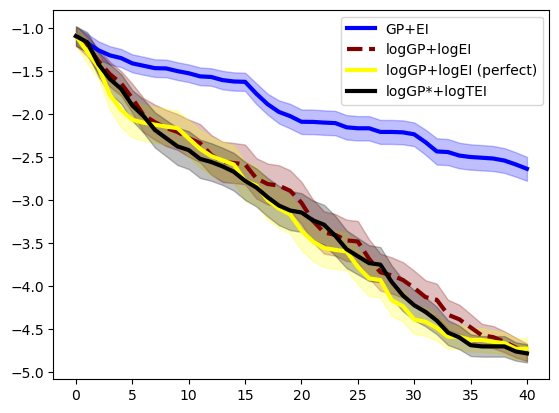

In [15]:
total_record = (np.array(EI_res2))
total_record[total_record<=0]=10**(-5)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP+EI',color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='blue')

total_record =  (np.array(logEI_noboundary_res))
total_record[total_record<=0]=10**(-5)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,linestyle='dashed',label='logGP+logEI',color='maroon')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='maroon')

total_record = (np.array(logEI_noboundary_perfect_res))
total_record[total_record<=0]=10**(-5)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='logGP+logEI (perfect)',color='yellow')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='yellow')


total_record =  (np.array(logEI_res))
total_record[total_record<=0]=10**(-5)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='logGP*+logTEI',color='black')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='black')

plt.legend()


In [16]:
np.savetxt('GP_res/logGP_discrete_GP_EI', EI_res2, delimiter=',')
np.savetxt('GP_res/logGP_discrete_logEI', logEI_noboundary_res, delimiter=',')
np.savetxt('GP_res/logGP_discrete_logEI(perfect)', logEI_noboundary_perfect_res, delimiter=',')
np.savetxt('GP_res/logGP_discrete_logTEI*', logEI_res, delimiter=',')

# Plot

In [5]:
import os

In [7]:
N = 50

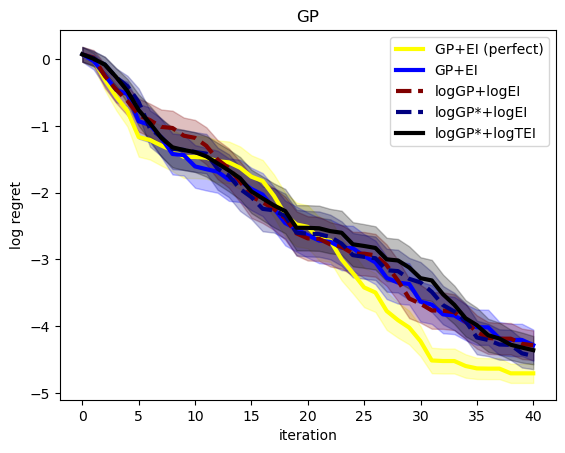

In [8]:
EI_res = np.genfromtxt(os.path.join(os.getcwd(),'GP_res/GP_discrete_GP_EI(perfect)'), delimiter=',')
EI_res2 = np.genfromtxt(os.path.join(os.getcwd(),'GP_res/GP_discrete_GP_EI'), delimiter=',')
logEI_noboundary_res = np.genfromtxt(os.path.join(os.getcwd(),'GP_res/GP_discrete_logEI'), delimiter=',')
logEI_res = np.genfromtxt(os.path.join(os.getcwd(),'GP_res/GP_discrete_logEI*'), delimiter=',')
logTEI_res = np.genfromtxt(os.path.join(os.getcwd(),'GP_res/GP_discrete_logTEI*'), delimiter=',')


total_record = (np.array(EI_res))
total_record[total_record<=0]=10**(-5)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP+EI (perfect)',color='yellow')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='yellow')

total_record = (np.array(EI_res2))
total_record[total_record<=0]=10**(-5)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP+EI',color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='blue')


total_record =  (np.array(logEI_noboundary_res))
total_record[total_record<=0]=10**(-5)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,linestyle='dashed',label='logGP+logEI',color='maroon')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='maroon')


total_record =  (np.array(logEI_res))
total_record[total_record<=0]=10**(-5)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,linestyle='dashed',label='logGP*+logEI',color='navy')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='navy')


total_record =  (np.array(logTEI_res))
total_record[total_record<=0]=10**(-5)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='logGP*+logTEI',color='black')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='black')

plt.xlabel('iteration')
plt.ylabel('log regret')
plt.title('GP')
plt.legend()

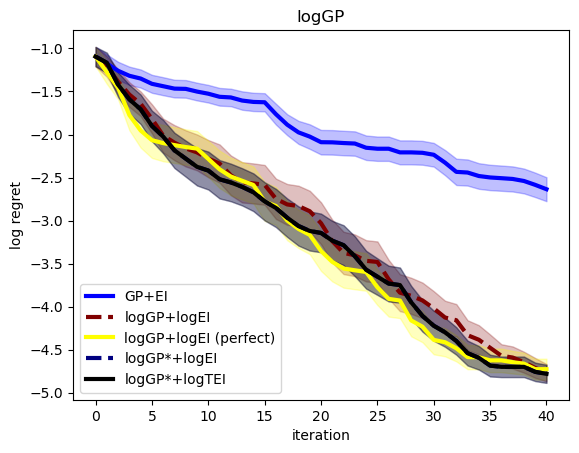

In [9]:
EI_res2 = np.genfromtxt(os.path.join(os.getcwd(),'GP_res/logGP_discrete_GP_EI'), delimiter=',')
logEI_noboundary_res = np.genfromtxt(os.path.join(os.getcwd(),'GP_res/logGP_discrete_logEI'), delimiter=',')
logEI_noboundary_perfect_res = np.genfromtxt(os.path.join(os.getcwd(),'GP_res/logGP_discrete_logEI(perfect)'), delimiter=',')
logEI_res = np.genfromtxt(os.path.join(os.getcwd(),'GP_res/logGP_discrete_logTEI*'), delimiter=',')


total_record = (np.array(EI_res2))
total_record[total_record<=0]=10**(-5)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP+EI',color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='blue')

total_record =  (np.array(logEI_noboundary_res))
total_record[total_record<=0]=10**(-5)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,linestyle='dashed',label='logGP+logEI',color='maroon')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='maroon')

total_record = (np.array(logEI_noboundary_perfect_res))
total_record[total_record<=0]=10**(-5)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='logGP+logEI (perfect)',color='yellow')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='yellow')

total_record =  (np.array(logEI_res))
total_record[total_record<=0]=10**(-5)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,linestyle='dashed',label='logGP*+logEI',color='navy')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='navy')

total_record =  (np.array(logEI_res))
total_record[total_record<=0]=10**(-5)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='logGP*+logTEI',color='black')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='black')

plt.xlabel('iteration')
plt.ylabel('log regret')
plt.title('logGP')
plt.legend()

# Analysis

In [87]:
class logGP_ObjectiveFunction3:  
    def __init__(self,X_history,Y_history,dim=2,lengthscale=0.2,variance=2,seed=0):
      
      self.dim = dim
      self.lengthscale = lengthscale
      self.variance = variance
      #self.bounds = torch.tensor([[0.,1.]]*dim).T
      self.npbounds = np.array([[0.,1.]]*dim)
      self.seed =seed
      
      self.X_history = X_history
      self.Y_history = Y_history
      
      np.random.seed(self.seed) 

      kernel = GPy.kern.RBF(input_dim=dim,variance=self.variance,lengthscale=self.lengthscale)
      model = GPy.models.GPRegression(self.X_history.reshape(-1,dim),self.Y_history.reshape(-1,1),kernel)
      model.Gaussian_noise.variance.fix(0.0)
      
      self.GP = model
      
    
    def return_logGP(self):
      
      X_total = high_dimensional_discretization(self.npbounds ,N=51)
      Y_total = self.GP.posterior_samples_f(X_total,size=1).reshape(-1,1)
      
      Y_total = np.exp(Y_total+2)-7.389
        
      return X_total, Y_total    
  
  
seed = 1234
np.random.seed(seed)

X0 = np.array([0.,0.]).reshape(-1,dim)
Y0 =np.array([np.random.normal(0, 0.1, size=(1,1))[0]]).reshape(-1,1)
fun = logGP_ObjectiveFunction3(X0,Y0,dim=2,lengthscale=0.1,variance=0.1**2,seed=seed)
X_total, Y_total    = fun.return_logGP()

X_init = []
Y_init = []

for ii in range(75):

    random.seed(ii)

    lower_bound = 0
    upper_bound = 51**2 - 1
    idx = random.randint(lower_bound, upper_bound)
    X_init.append(X_total[idx])
    Y_init.append(Y_total[idx])
    
X_BO = np.array(X_init)
Y_BO = np.array(Y_init)

minimal output is  -1.9935918111168034


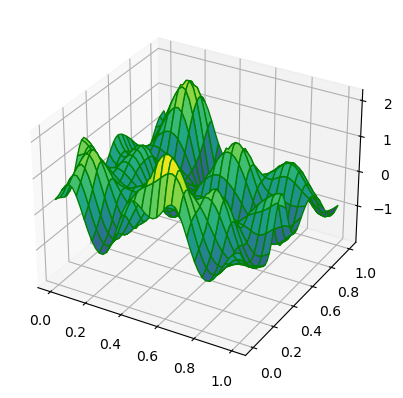

In [64]:
print('minimal output is ',np.min(Y_total))

X1 = np.linspace(0,1,51)
X2 = np.linspace(0,1,51)

X1X2, X2X1 = np.meshgrid(X1,X2)

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1X2, X2X1, Y_total.reshape(51,51), cmap ='viridis', edgecolor ='green')

plt.show()

In [88]:
kernel = GPy.kern.RBF(input_dim=2)
m = GPy.models.GPRegression(X_BO.reshape(-1,2),Y_BO.reshape(-1,1),kernel)
m.Gaussian_noise.variance.fix(0.)
m.optimize_restarts(num_restarts = 10)
m

Optimization restart 1/10, f = 25.52529704576927
Optimization restart 2/10, f = 25.525297045764383
Optimization restart 3/10, f = 25.525297040235557
Optimization restart 4/10, f = 25.52529704330707
Optimization restart 5/10, f = 25.5252970442033
Optimization restart 6/10, f = 25.525297045765527
Optimization restart 7/10, f = 25.525297048539805
Optimization restart 8/10, f = 25.52529704387655
Optimization restart 9/10, f = 25.525297045764212
Optimization restart 10/10, f = 25.52529704576424


GP_regression.,value,constraints,priors
rbf.variance,0.5093057444338951,+ve,
rbf.lengthscale,0.09397198604043618,+ve,
Gaussian_noise.variance,0.0,+ve fixed,
